# 1. Overview

# 2. Forecasting

## 2.1 Import Libraries

In [1]:
# pip install prophet

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import logging
import itertools
import joblib
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from prophet import Prophet
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sktime.forecasting.naive import NaiveForecaster
from sktime.utils.plotting import plot_series
from sklearn.metrics import mean_absolute_percentage_error, root_mean_squared_error
from sklearn.model_selection import GridSearchCV, ParameterGrid

# Desactivar logs de Prophet
logging.getLogger('cmdstanpy').disabled = True

C:\Users\Usuario\anaconda3\envs\forecastingv2\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


## 2.2 Define Global variables

In [3]:
input_data = 'data/weekly_data.csv'
output_model_path = 'models/prophet_simple_asml_model.pkl'

## 2.3 Functions

In [4]:
# Feature engineering for time series
def create_features(df):
    """
    Create time-based features for time series data.
    
    Input:
    - df: DataFrame with a datetime index and a single column for the target variable.

    Output:
    - df: DataFrame with added columns for year, month, week of the year, quarter, and cuatrimestre.

    Logic:
    - Extracts the 'year', 'month', 'week_of_year', 'quarter', and 'cuatrimestre' 
      from the datetime index to create additional time-based features.
    """
    df = df.copy()  # Create a copy of the DataFrame to avoid the warning
    df['year'] = df.index.year            # Extract year from the date
    df['month'] = df.index.month          # Extract month from the date
    df['week_of_year'] = df.index.isocalendar().week  # Extract week of the year from the date
    df['quarter'] = df.index.quarter      # Extract quarter from the date
    df['cuatrimestre'] = ((df.index.month - 1) // 4) + 1  # Calculate cuatrimestre (four-month period)
    return df

## 2.4 Code

In [5]:
weekly_data = pd.read_csv(input_data, sep=';')

# Ensure the 'Date' column is in datetime format
weekly_data['Date'] = pd.to_datetime(weekly_data['Date'])

# Set the 'Date' column as the index to make it a DatetimeIndex
weekly_data.set_index('Date', inplace=True)

# Explicitly set the frequency of the Date index
weekly_data = weekly_data.asfreq('W')

weekly_data.head()

,Close
Date,
2013-01-13,56.677265
2013-01-20,57.336109
2013-01-27,62.250618
2013-02-03,67.013779
2013-02-10,67.654816


### 2.4.1 Train test split

In [6]:
train_data = weekly_data[:-12]
train_data

,Close
Date,
2013-01-13,56.677265
2013-01-20,57.336109
2013-01-27,62.250618
2013-02-03,67.013779
2013-02-10,67.654816
...,...
2024-07-07,1069.428589
2024-07-14,1075.397461
2024-07-21,930.336243


In [7]:
test_data = weekly_data[-12:]
test_data

,Close
Date,
2024-08-11,843.010010
2024-08-18,879.580017
2024-08-25,926.179993
2024-09-01,888.130005
2024-09-08,811.479980
2024-09-15,800.140015
2024-09-22,803.039978
2024-09-29,818.179993
2024-10-06,832.409973


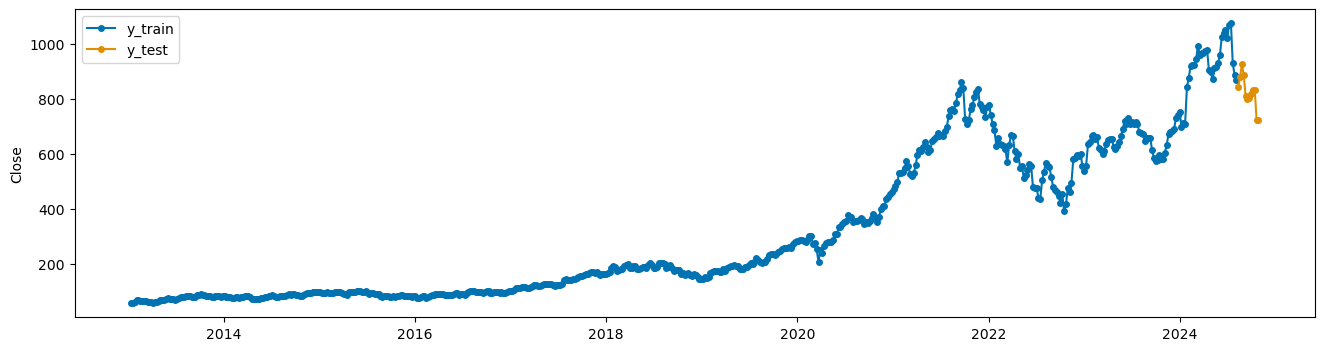

In [8]:
plot_series(train_data, test_data, labels=["y_train", "y_test"]);

### 2.4.2 Naive forecaster

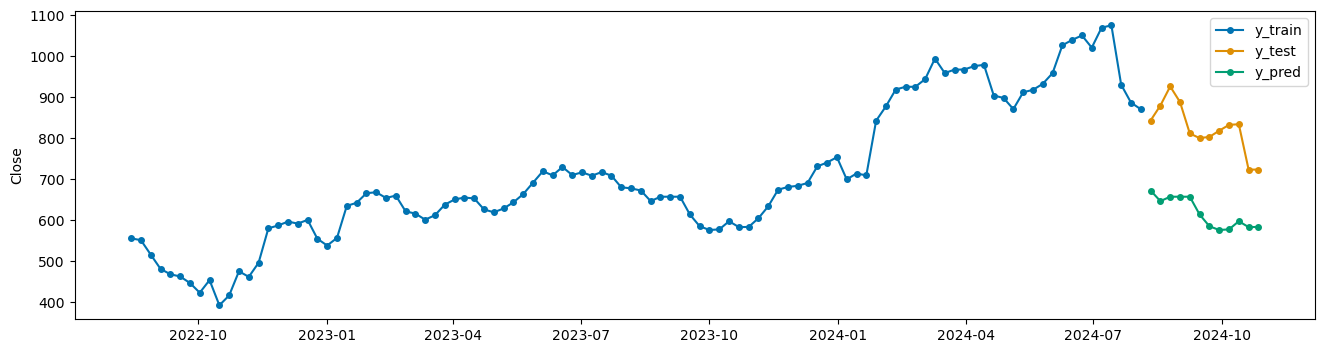

In [9]:
# Initialize the Naive Forecaster (strategy = 'last' means it will use the last value)
naive_forecaster = NaiveForecaster(strategy="last", sp=52)

# Fit the model to the training data
naive_forecaster.fit(train_data)

# Make predictions on the test set
y_pred_naive = naive_forecaster.predict(fh=[i+1 for i in range(len(test_data))])

# Plot the training, test data, and predictions
plot_series(train_data[500:], test_data, y_pred_naive, labels=["y_train", "y_test", "y_pred"]);


Now we are going to calculate the metrics of the model. The RMSE and the MAPE

In [10]:
mape_naive = mean_absolute_percentage_error(test_data, y_pred_naive) * 100
mape_naive

24.891185667900636

In [11]:
rmse_naive = root_mean_squared_error(test_data, y_pred_naive)
rmse_naive

211.05090975803688

### 2.4.3 ETS 

Initialize the ETS model with additive trend and seasonality 'seasonal_periods' should be set based on the periodicity of the data

In [12]:
ets_model_add = ExponentialSmoothing(
    train_data, 
    trend='add',          # Can also use 'mul' for multiplicative trend
    seasonal='add',       # Can also use 'mul' for multiplicative seasonality
    seasonal_periods=52   # Adjust based on the seasonality of your data (e.g., 52 for weekly data)
)

Fit the model to the training data

In [13]:
fitted_model_add = ets_model_add.fit()

Generate predictions for the test set

In [14]:
y_pred_ets_add = fitted_model_add.forecast(len(test_data))

Plot the training, test data, and predictions

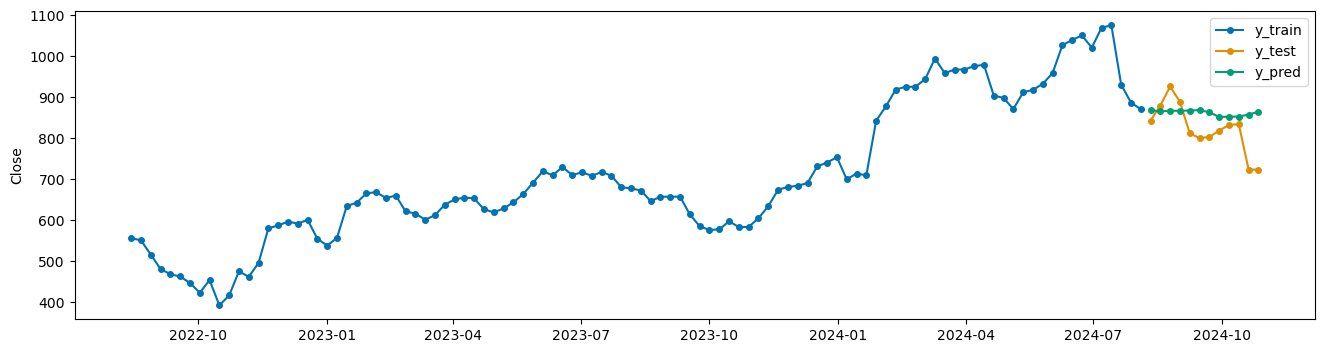

In [15]:
plot_series(train_data[500:], test_data, y_pred_ets_add, labels=["y_train", "y_test", "y_pred"]);

Now we are going to calculate the metrics of the model. The RMSE and the MAPE

In [16]:
mape_ets_add = mean_absolute_percentage_error(test_data, y_pred_ets_add) * 100
mape_ets_add

6.933087168683802

In [17]:
rmse_ets_add = root_mean_squared_error(test_data, y_pred_ets_add)
rmse_ets_add

68.3794667654434

We are going to retry the ETS model but now we are going to modify the trend and seasonality to be multiplicative

In [18]:
ets_model_mul = ExponentialSmoothing(
    train_data, 
    trend='mul',          # Can also use 'add' for additive trend
    seasonal='mul',       # Can also use 'add' for additive seasonality
    seasonal_periods=52   # Adjust based on the seasonality of your data (e.g., 52 for weekly data)
)

Fit the model to the training data

In [19]:
fitted_model_mul = ets_model_mul.fit()

C:\Users\Usuario\anaconda3\envs\forecastingv2\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


Generate predictions for the test set

In [20]:
y_pred_ets_mul = fitted_model_mul.forecast(len(test_data))

Plot the training, test data, and predictions

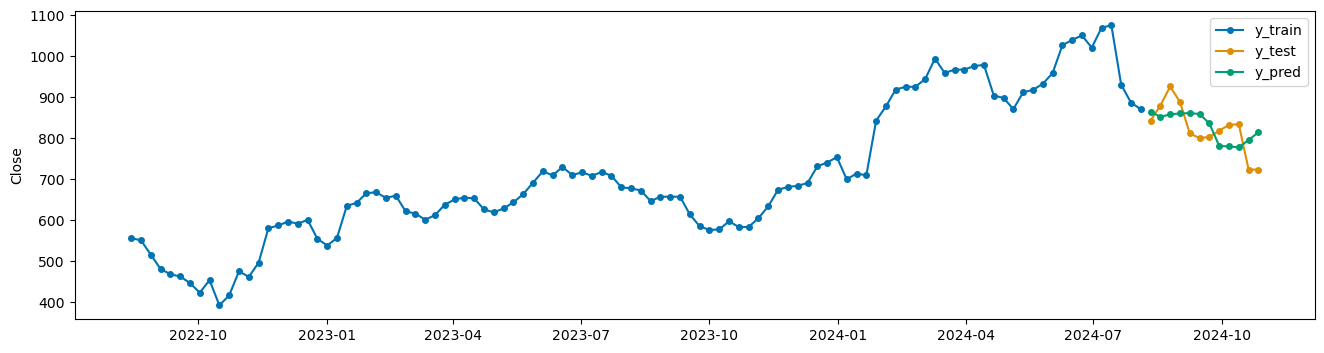

In [21]:
plot_series(train_data[500:], test_data, y_pred_ets_mul, labels=["y_train", "y_test", "y_pred"]);

Now we are going to calculate the metrics of the model. The RMSE and the MAPE

In [22]:
mape_ets_mul = mean_absolute_percentage_error(test_data, y_pred_ets_mul) * 100
mape_ets_mul

6.160616399412125

In [23]:
rmse_ets_mul = root_mean_squared_error(test_data, y_pred_ets_mul)
rmse_ets_mul

53.602260512412364

### 2.4.4 SARIMA

Step 1: Log transformation (to stabilize variance)

In [24]:
log_train_data = np.log(train_data)

Step 2: Check stationarity using the Augmented Dickey-Fuller test and Differencing if necessary

In [25]:
# Augmented Dickey-Fuller test
result = adfuller(log_train_data, autolag='AIC')
p_value = result[1]
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {p_value}')

if p_value > 0.05:
    print("The series is not stationary. Applying differencing.")
    # Differencing to achieve stationarity
    diff_log_train_data = log_train_data.diff().dropna()

    # Check stationarity again after differencing
    result_diff = adfuller(diff_log_train_data, autolag='AIC')
    p_value_diff = result_diff[1]
    print(f'ADF Statistic after differencing: {result_diff[0]}')
    print(f'p-value after differencing: {p_value_diff}')

    if p_value_diff > 0.05:
        print("The series is still not stationary.")
    else:
        print("The series is now stationary with differencing.")
    train_data_stationary = diff_log_train_data
else:
    print("The series is stationary with only log.")
    train_data_stationary = log_train_data

ADF Statistic: -0.5335713221763658
p-value: 0.8852971232123715
The series is not stationary. Applying differencing.
ADF Statistic after differencing: -22.018056638975455
p-value after differencing: 0.0
The series is now stationary with differencing.


Plot the transformed data to visualize

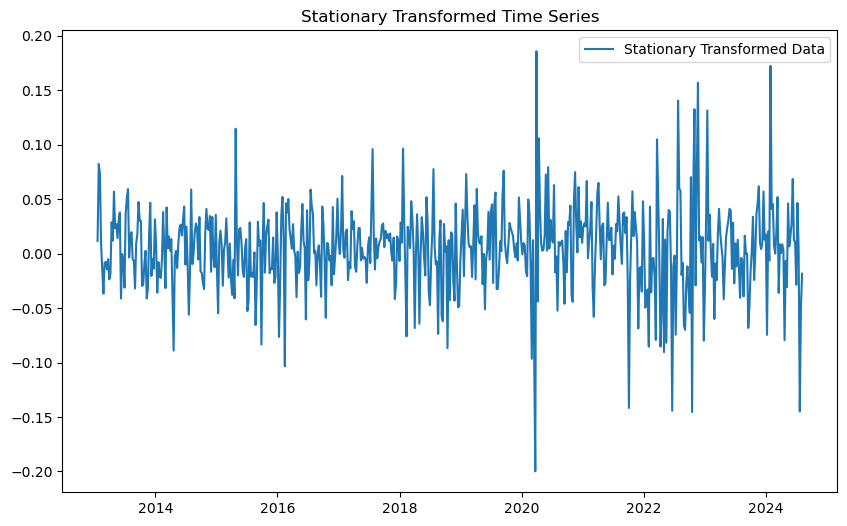

In [26]:
plt.figure(figsize=(10, 6))
plt.plot(train_data_stationary, label='Stationary Transformed Data')
plt.title('Stationary Transformed Time Series')
plt.legend()
plt.show()

Initialize the SARIMA Model

In [27]:
sarima_model = SARIMAX(
    train_data_stationary,     # Training data that is stationary
    order=(1, 1, 1),           # ARIMA order (p, d, q)
    seasonal_order=(1, 1, 1, 52),  # Seasonal order (P, D, Q, s), here s=52 for weekly data
    enforce_stationarity=False,  # Allow the model to be non-stationary
    enforce_invertibility=False  # Allow the model to be non-invertible
)

In [28]:
# Fit the model to the training data
fitted_sarima = sarima_model.fit(disp=False)

In [29]:
# Generate predictions for the test set
y_pred_sarima = fitted_sarima.forecast(steps=len(test_data))

Now we have to revert the transformations

In [30]:
# Step 1: Revert the differencing
# 'last_original_value' is the last value before differencing was applied
last_original_value = log_train_data.iloc[-1]

# Add back the last original value to get the cumulative sum and revert differencing
y_pred_sarima_diff_reverted = np.r_[last_original_value, y_pred_sarima].cumsum()

# Remove the first value to match the length of test_data
y_pred_sarima_diff_reverted = y_pred_sarima_diff_reverted[1:]

# Step 2: Revert the logarithmic transformation
y_pred_sarima_reverted = np.exp(y_pred_sarima_diff_reverted)

# Convert the reverted predictions to a pandas Series
y_pred_sarima_reverted = pd.Series(y_pred_sarima_reverted, index=test_data.index)

Let's plot the data and predictions

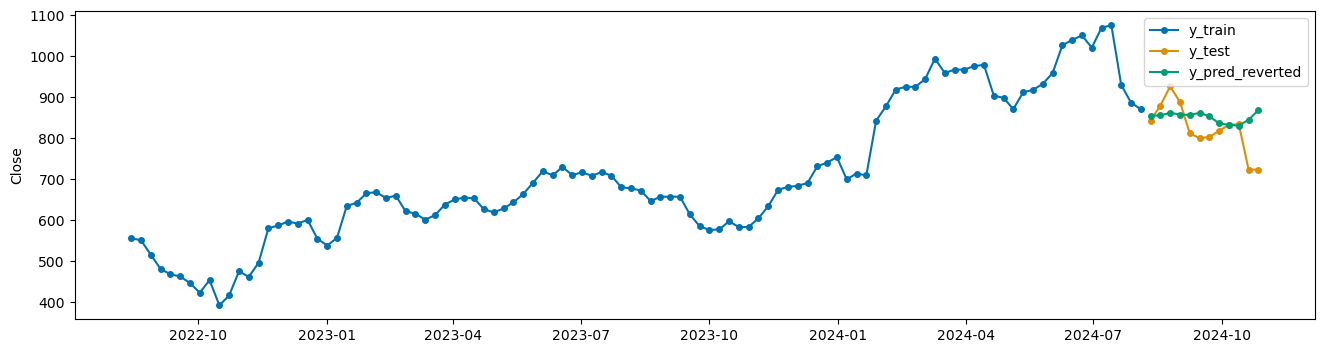

In [31]:
# Plot the training, test data, and predictions
plot_series(train_data[500:], test_data, y_pred_sarima_reverted, labels=["y_train", "y_test", "y_pred_reverted"]);

In [32]:
# Calculate MAPE for SARIMA model
mape_sarima = mean_absolute_percentage_error(test_data, y_pred_sarima_reverted) * 100
mape_sarima

6.129764284987541

In [33]:
# Calculate RMSE for SARIMA model
rmse_sarima = root_mean_squared_error(test_data, y_pred_sarima_reverted)
rmse_sarima

64.77053787082251

### 2.4.5 Prophet

Initialize the Prophet model

In [34]:
prophet_model = Prophet()

Fit the model to the data

First we need to modify the column names as is required by prophet

In [35]:
train_data_prophet = train_data.reset_index(names="ds").rename(columns={'Close':'y'})
train_data_prophet

,ds,y
0,2013-01-13,56.677265
1,2013-01-20,57.336109
2,2013-01-27,62.250618
3,2013-02-03,67.013779
4,2013-02-10,67.654816
...,...,...
599,2024-07-07,1069.428589
600,2024-07-14,1075.397461
601,2024-07-21,930.336243
602,2024-07-28,886.747009


In [36]:
prophet_model.fit(train_data_prophet)

In [37]:
# Define the forecast horizon (e.g., 8 periods into the future)
future = prophet_model.make_future_dataframe(periods=12, freq='W')

# Generate predictions
forecast = prophet_model.predict(future)

Plot forecast components (trend, weekly, yearly components)

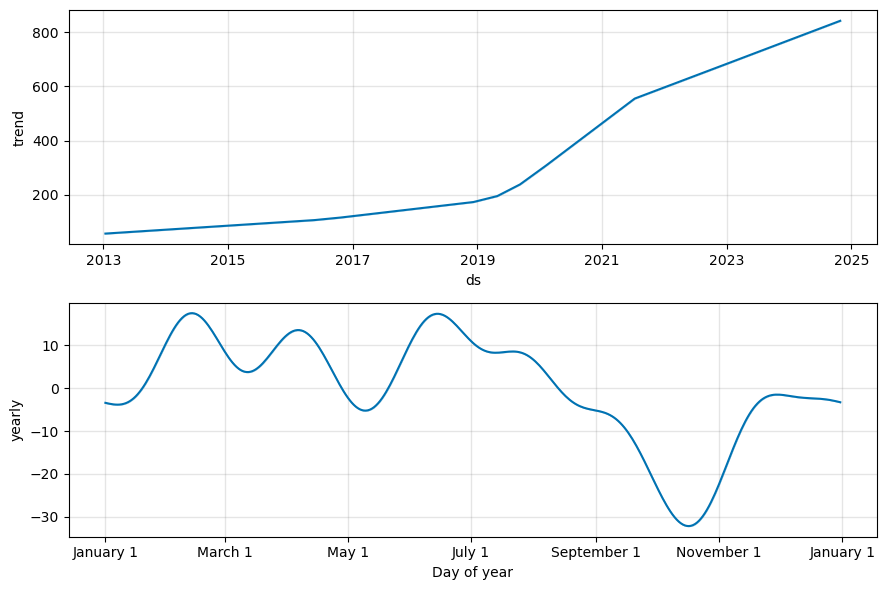

In [38]:
fig2 = prophet_model.plot_components(forecast)
plt.show()

In [39]:
# Return to the original DataFrame format with 'ds' as index and 'yhat' as 'Close'
forecast = forecast[['ds', 'yhat']].set_index('ds').rename(columns={'yhat': 'Close'})[-12:]

forecast

,Close
ds,
2024-08-11,824.933510
2024-08-18,823.027953
2024-08-25,822.690817
2024-09-01,823.564322
2024-09-08,824.119265
2024-09-15,822.850726
2024-09-22,819.299525
2024-09-29,814.301971
2024-10-06,809.607682


In [40]:
# Ensure ds is the index of train_data_prophet 
train_data_prophet = train_data_prophet.set_index('ds')

Plot the forecast results

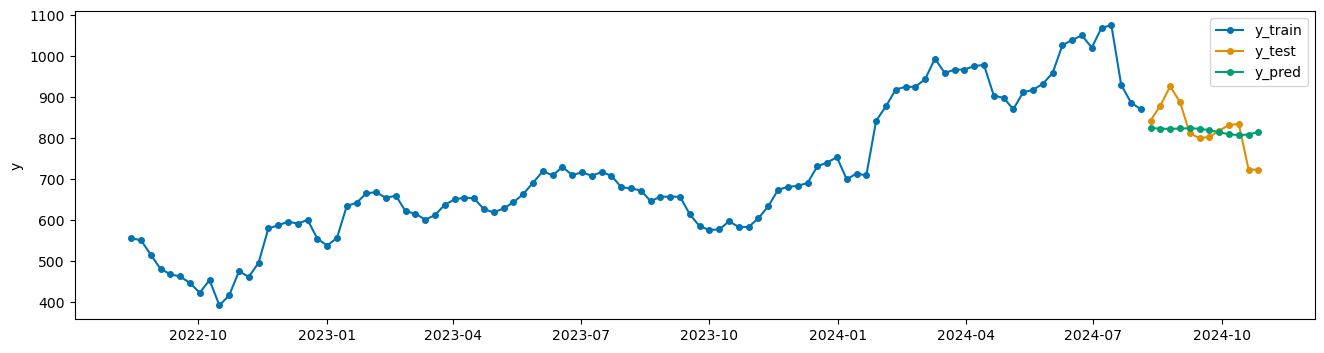

In [41]:
plot_series(train_data_prophet[500:], test_data, forecast, labels=["y_train", "y_test", "y_pred"]);

Now we are going to calculate the metrics of the model. The RMSE and the MAPE

In [42]:
mape_prophet = mean_absolute_percentage_error(test_data, forecast) * 100
mape_prophet

5.36336877115334

In [43]:
rmse_prophet = root_mean_squared_error(test_data, forecast)
rmse_prophet

55.013338778410336

### 2.4.6 XGboost

In [44]:
train_data_xgb_rf = create_features(train_data)
test_data_xgb_rf = create_features(test_data)

In [45]:
# Prepare X and y for the model
# Since we're not adding any features, we simply use the index as an integer sequence
X_train_xgb = train_data_xgb_rf.drop('Close', axis=1)
y_train_xgb = train_data_xgb_rf['Close']
X_test_xgb = test_data_xgb_rf.drop('Close', axis=1)
y_test_xgb = test_data_xgb_rf['Close']

In [46]:
# Initialize the XGBoost model
xgb_model = XGBRegressor(
    n_estimators=100,       # Number of trees
    learning_rate=0.1,      # Step size shrinkage
    max_depth=5,            # Maximum depth of trees
    random_state=42         # For reproducibility
)

In [47]:
# Train the model
xgb_model.fit(X_train_xgb, y_train_xgb)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [48]:
# Generate predictions
y_pred_xgb = xgb_model.predict(X_test_xgb)
y_pred_xgb = pd.DataFrame(y_pred_xgb, index=test_data.index, columns=['Close'])

In [49]:
# Evaluate the model's performance
rmse_xgb = root_mean_squared_error(y_test_xgb, y_pred_xgb)
rmse_xgb

70.56541789124057

In [50]:
mape_xgb = mean_absolute_percentage_error(y_test_xgb, y_pred_xgb)*100
mape_xgb

7.290917495795725

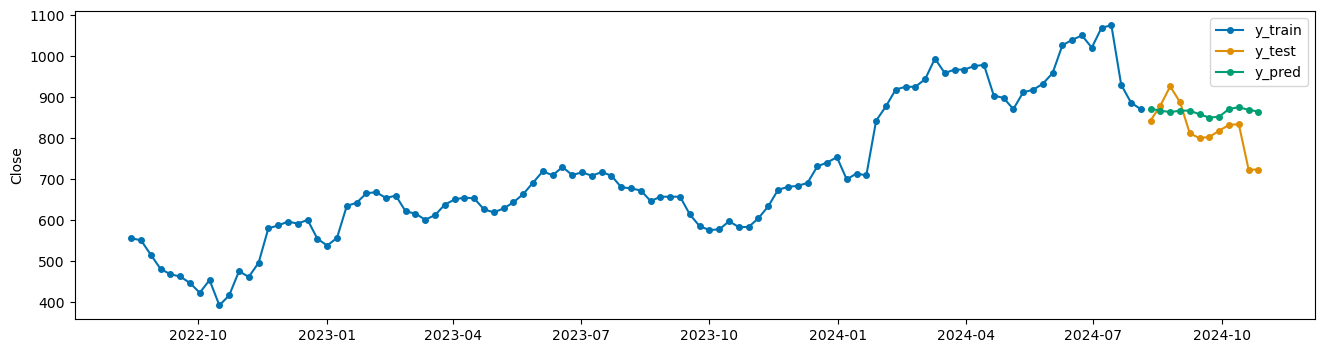

In [51]:
# Plot actual vs. predicted values
plot_series(y_train_xgb[500:], y_test_xgb, y_pred_xgb, labels=["y_train", "y_test", "y_pred"]);

### 2.4.7 Random Forest

In [52]:
# Prepare X and y for the model
# Since we're not adding any features, we simply use the index as an integer sequence
X_train_rf = train_data_xgb_rf.drop('Close', axis=1)
y_train_rf = train_data_xgb_rf['Close']
X_test_rf = test_data_xgb_rf.drop('Close', axis=1)
y_test_rf = test_data_xgb_rf['Close']

In [53]:
# Initialize the Random Forest model
rf_model = RandomForestRegressor(
    n_estimators=100,       # Number of trees
    max_depth=5,            # Maximum depth of trees
    random_state=42         # For reproducibility
)

In [54]:
# Train the model
rf_model.fit(X_train_rf, y_train_rf)

RandomForestRegressor(max_depth=5, random_state=42)

In [55]:
# Generate predictions
y_pred_rf = rf_model.predict(X_test_rf)

# Convert predictions to a DataFrame with the same index as the test data
y_pred_rf = pd.DataFrame(y_pred_rf, index=test_data.index, columns=['Close'])

In [56]:
# Evaluate the model's performance
rmse_rf = root_mean_squared_error(y_test_rf, y_pred_rf)
rmse_rf

95.4295610734148

In [57]:
mape_rf = mean_absolute_percentage_error(y_test_rf, y_pred_rf)*100
mape_rf

10.27227195307005

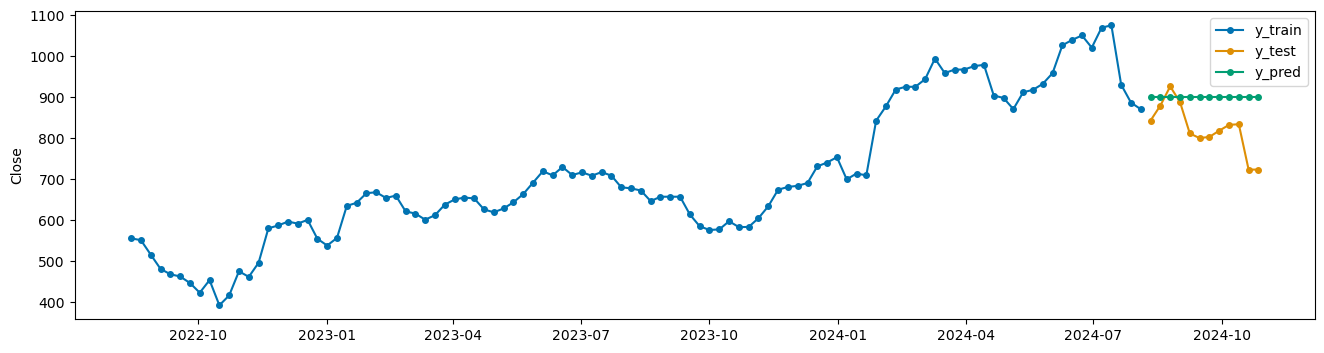

In [58]:
# Plot actual vs. predicted values
plot_series(y_train_rf[500:], y_test_rf, y_pred_rf, labels=["y_train", "y_test", "y_pred"]);

### 2.4.8 RMSE and MAPE comparison

In [59]:
# Create a dictionary to store RMSE and MAPE for each model
metrics = {
    "Model": ["Naive", "ETS (Additive)", "ETS (Multiplicative)", "SARIMA", "Prophet", "XGBoost", "Random Forest"],
    "RMSE": [
        rmse_naive,
        rmse_ets_add,
        rmse_ets_mul,
        rmse_sarima,
        rmse_prophet,
        rmse_xgb,
        rmse_rf
    ],
    "MAPE": [
        mape_naive,
        mape_ets_add,
        mape_ets_mul,
        mape_sarima,
        mape_prophet,
        mape_xgb,
        mape_rf
    ]
}

In [60]:
# Convert the dictionary to a pandas DataFrame
metrics_df = pd.DataFrame(metrics)

metrics_df

,Model,RMSE,MAPE
0,Naive,211.050910,24.891186
1,ETS (Additive),68.379467,6.933087
2,ETS (Multiplicative),53.602261,6.160616
3,SARIMA,64.770538,6.129764
4,Prophet,55.013339,5.363369
5,XGBoost,70.565418,7.290917
6,Random Forest,95.429561,10.272272


Our best model is Prophet as it has the lowest RMSE and MAPE

### 2.4.9 Fine-tunning

Let's investigate the following models after doing a fine-tunning: SARIMA, Prophet, and XGBoost

#### 2.4.9.1 SARIMA

We have commented the code below as the code takes 7 hrs to run

In [61]:
# # Define the range of values for the parameters (p, d, q) and seasonal parameters (P, D, Q, s)
# p = d = q = range(0, 3)
# pdq = list(itertools.product(p, d, q))
# seasonal_pdq = [(x[0], x[1], x[2], 52) for x in list(itertools.product(p, d, q))]

# # Define variables to store the best model and its MAPE and RMSE
# best_mape = np.inf
# best_rmse = np.inf
# best_pdq = None
# best_seasonal_pdq = None
# best_model = None

# # Grid search
# total_combinations = len(pdq) * len(seasonal_pdq)  # Calculate total combinations
# current_combination = 0  # Counter for current combinations

# for param in pdq:
#     for seasonal_param in seasonal_pdq:
#         current_combination += 1
#         print(f"Testing combination {current_combination}/{total_combinations} -> order={param}, seasonal_order={seasonal_param}")

#         try:
#             # Fit the SARIMA model with current parameters
#             model = SARIMAX(train_data_stationary, 
#                             order=param, 
#                             seasonal_order=seasonal_param,
#                             enforce_stationarity=False, 
#                             enforce_invertibility=False)
#             results = model.fit(disp=False)
            
#             # Calculate the model's predictions
#             predictions = results.predict(start=0, end=len(train_data_stationary)-1)
            
#             # Calculate MAPE and RMSE
#             mape = np.mean(np.abs((train_data_stationary - predictions) / train_data_stationary)) * 100
#             rmse = np.sqrt(np.mean((train_data_stationary - predictions) ** 2))
            
#             # Update best model if its MAPE and RMSE are lower than the best found so far
#             if mape < best_mape and rmse < best_rmse:
#                 best_mape = mape
#                 best_rmse = rmse
#                 best_pdq = param
#                 best_seasonal_pdq = seasonal_param
#                 best_model = results

#         except Exception as e:
#             print(f"Error in combination {current_combination}: {e}")
#             continue

# print(f'\nBest SARIMA model: order={best_pdq}, seasonal_order={best_seasonal_pdq} with MAPE={best_mape} and RMSE={best_rmse}')


Looking at the results the SARIMA optimization doesn't converge therefore we won't take it into account.

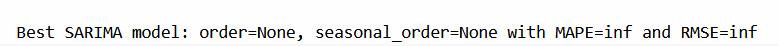

#### 2.4.9.2 Prophet

In [62]:
# Define the range of parameters
param_grid = {
    'seasonality_mode': ['additive', 'multiplicative'],
    'changepoint_prior_scale': [0.01, 0.1, 0.5, 1.0],
    'seasonality_prior_scale': [0.1, 1.0, 10.0],
    'holidays_prior_scale': [0.1, 1.0, 10.0]
}

# Create combinations of parameters
grid = ParameterGrid(param_grid)

best_mape = float('inf')
best_params = None
best_model = None

for params in grid:
    model = Prophet(
        seasonality_mode=params['seasonality_mode'],
        changepoint_prior_scale=params['changepoint_prior_scale'],
        seasonality_prior_scale=params['seasonality_prior_scale'],
        holidays_prior_scale=params['holidays_prior_scale']
    )
    
    train_data_prophet = train_data.reset_index(names="ds").rename(columns={'Close':'y'})
    
    model.fit(train_data_prophet)

    # Generate predictions
    future = model.make_future_dataframe(periods=12, freq='W')
    forecast = model.predict(future)
    forecast_filtered = forecast[['ds', 'yhat']].set_index('ds').rename(columns={'yhat': 'Close'})
    
    # Calculate MAPE
    mape = mean_absolute_percentage_error(test_data['Close'], forecast_filtered.loc[test_data.index])
    
    if mape < best_mape:
        best_mape = mape
        best_params = params
        best_model = model

print(f"Best parameters: {best_params} with MAPE: {best_mape}")

Best parameters: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0} with MAPE: 0.049633752847964896


Let's now do again the prophet model with the best parameters

Initialize the Prophet model

In [63]:
prophet_model_best = Prophet(
        changepoint_prior_scale=0.01,
        holidays_prior_scale=0.1,
        seasonality_mode='multiplicative',
        seasonality_prior_scale=1.0
)

Fit the model to the data

First we need to modify the column names as is required by prophet

In [64]:
train_data_prophet = train_data.reset_index(names="ds").rename(columns={'Close':'y'})
train_data_prophet

,ds,y
0,2013-01-13,56.677265
1,2013-01-20,57.336109
2,2013-01-27,62.250618
3,2013-02-03,67.013779
4,2013-02-10,67.654816
...,...,...
599,2024-07-07,1069.428589
600,2024-07-14,1075.397461
601,2024-07-21,930.336243
602,2024-07-28,886.747009


In [65]:
prophet_model_best.fit(train_data_prophet)

In [66]:
# Define the forecast horizon (e.g., 8 periods into the future)
future_best = prophet_model_best.make_future_dataframe(periods=12, freq='W')

# Generate predictions
forecast_best = prophet_model_best.predict(future_best)

Plot forecast components (trend, weekly, yearly components)

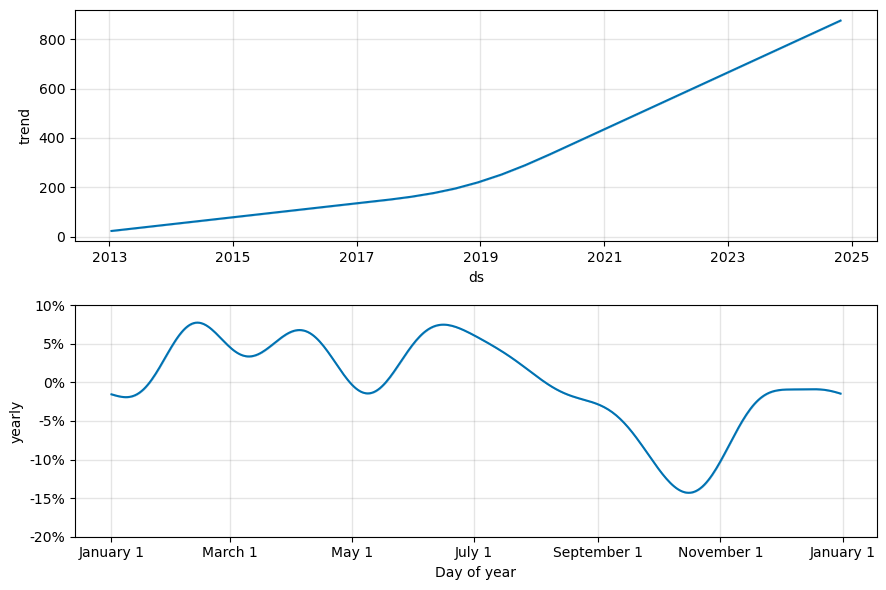

In [67]:
fig2 = prophet_model_best.plot_components(forecast_best)
plt.show()

In [68]:
# Return to the original DataFrame format with 'ds' as index and 'yhat' as 'Close'
forecast_best = forecast_best[['ds', 'yhat']].set_index('ds').rename(columns={'yhat': 'Close'})[-12:]

forecast_best

,Close
ds,
2024-08-11,844.251927
2024-08-18,839.527763
2024-08-25,836.973894
2024-09-01,833.984329
2024-09-08,827.243020
2024-09-15,814.632026
2024-09-22,796.567892
2024-09-29,776.117112
2024-10-06,758.205932


In [69]:
# Ensure ds is the index of train_data_prophet 
train_data_prophet = train_data_prophet.set_index('ds')

Plot the forecast results

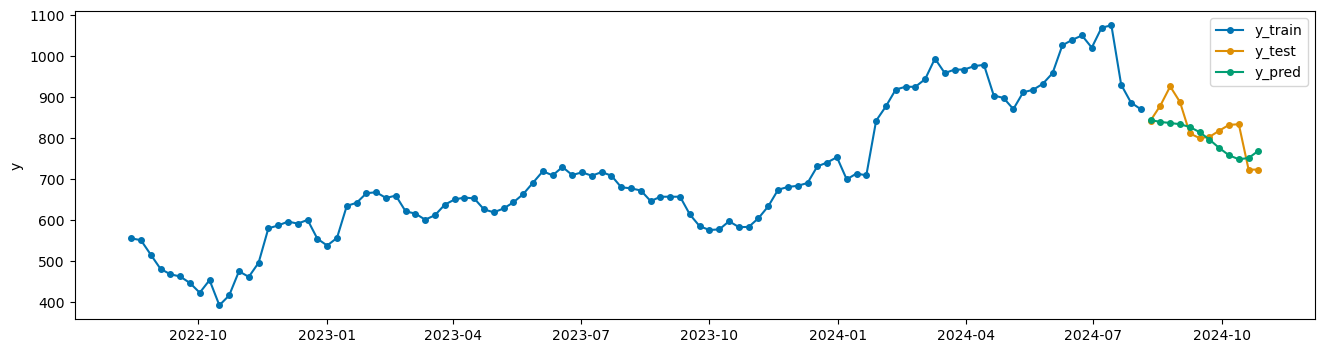

In [70]:
plot_series(train_data_prophet[500:], test_data, forecast_best, labels=["y_train", "y_test", "y_pred"]);

Now we are going to calculate the metrics of the model. The RMSE and the MAPE

In [71]:
mape_prophet_best = mean_absolute_percentage_error(test_data, forecast_best) * 100
mape_prophet_best

4.96337528479649

In [72]:
rmse_prophet_best = root_mean_squared_error(test_data, forecast_best)
rmse_prophet_best

50.40997738424668

#### 2.4.9.3 XGB

In [73]:
# Define the parameter grid
param_grid_xgb = {
    'n_estimators': [50, 100, 150],       # Number of trees
    'learning_rate': [0.01, 0.1, 0.2],    # Step size shrinkage
    'max_depth': [3, 5, 7],               # Maximum depth of trees
    'random_state': [42]                  # For reproducibility
}

In [74]:
# Initialize the XGBoost model
xgb_model = XGBRegressor()

In [75]:
# Set up the GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid_xgb,
    scoring='neg_mean_absolute_error',  # Use MAE as the scoring metric
    cv=3,                               # 5-fold cross-validation
    n_jobs=-1,                          # Use all available cores
    verbose=1                           # Show the training process
)

In [76]:
# Fit the GridSearchCV to the training data
grid_search.fit(X_train_xgb, y_train_xgb)

# Get the best parameters found
best_params = grid_search.best_params_
print(f"Best parameters found: {best_params}")

# Get the best model
best_xgb_model = grid_search.best_estimator_

# Make predictions with the best model
y_pred_xgb_best = best_xgb_model.predict(X_test_xgb)

# Convert predictions to a DataFrame with the same index as test_data
y_pred_xgb_best = pd.DataFrame(y_pred_xgb_best, index=test_data.index, columns=['Close'])


Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best parameters found: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 150, 'random_state': 42}


In [77]:
# Evaluate the model's performance
rmse_xgb = root_mean_squared_error(y_test_xgb, y_pred_xgb_best)
rmse_xgb

73.26363518549587

In [78]:
mape_xgb = mean_absolute_percentage_error(y_test_xgb, y_pred_xgb_best)*100
mape_xgb

7.565376390757217

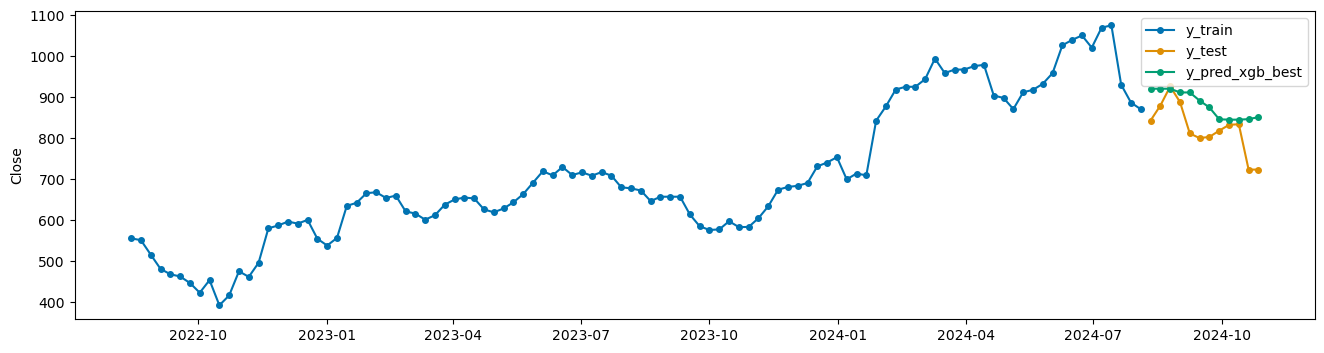

In [79]:
# Plot actual vs. predicted values
plot_series(y_train_xgb[500:], y_test_xgb, y_pred_xgb_best, labels=["y_train", "y_test", "y_pred_xgb_best"]);

#### 2.4.9.4 Results

The final chosen model is the prophet as the MAPE improved from 5.36 to 4.96 and RMSE 55.01 to 50.41

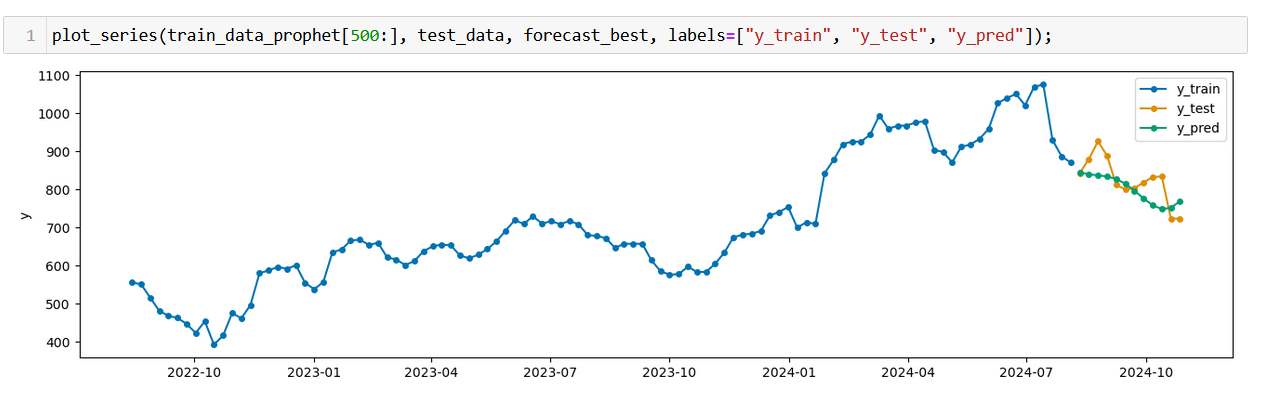

#### 2.4.9.5 Save the best model

In [80]:
joblib.dump(prophet_model_best, output_model_path)

['models/prophet_simple_asml_model.pkl']